<a href="https://colab.research.google.com/github/big-muzzy/Autoencoders/blob/master/convolutional_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random as rnd

from tensorflow.keras.datasets import mnist, fashion_mnist, cifar10
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Conv2DTranspose, Input, concatenate, Reshape, Flatten, Dropout, BatchNormalization
from tensorflow.keras import utils
from tensorflow.keras.preprocessing import image # модуль для отрисовки изображения



Несколько вспомогательных функций.

Функция для вывода изображений

In [2]:
def plotImages(startIndex, pred): # создадим функцию для вывода изображений как картинок
  n = 10  # количество картинок, которые хотим показать
  plt.figure(figsize=(17, 3)) # указываем размеры фигуры
  for i in range(n): # для каждой картинки из n(5)
      index = i + startIndex # startIndex - начиная с какого индекса хотим заплотить картинки
      ax = plt.subplot(2, n, i + 1 + n) # выведем область рисования Axes 
      plt.imshow(pred[index].reshape(28, 28)) # отрисуем обработанные сеткой картинки в размере 28*28
      plt.gray() # выведем в черно-белом цвете
      ax.get_xaxis().set_visible(False) # скрываем вывод координатной оси x
      ax.get_yaxis().set_visible(False) # скрываем вывод координатной оси y
  plt.show()


Функция для рисования графика обучения нейросети.

In [3]:
def plotGraph(acc, valacc):
  plt.plot(acc, label='Обучающий набор')
  plt.plot(valacc, label='Проверочный набор')
  plt.xlabel('Эпохи обучения')
  plt.ylabel('Точность')
  plt.legend()
  plt.show()

Загружаем данные - MNIST. Набор рукописных цифр.

In [4]:
(xtrain_org, ytrain_org), (xtest_org, ytest_org) = mnist.load_data()
xtrain = xtrain_org.astype(float) / 255. 
xtrain = xtrain.reshape(60000, 28, 28, 1)
xtest = xtest_org.astype(float) / 255. 
xtest = xtest.reshape(10000, 28, 28, 1)

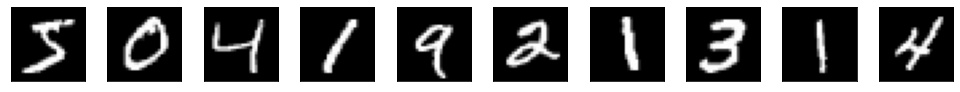

In [5]:
plotImages(0, xtrain)

Модель автокодировщика с использованием сверточных слоев.

In [6]:
def createConvModel():
  model = Sequential()
  model.add(Conv2D(128, (3, 3), padding='same', activation='relu', input_shape=xtrain.shape[1:]))
  model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
  model.add(MaxPooling2D((2, 2))) #14x14
  model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
  model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
  model.add(MaxPooling2D((2, 2))) #7x7
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(7*7*64, activation='relu'))
  model.add(Reshape((7, 7, 64)))
  model.add(Conv2DTranspose(128, (2, 2), strides=2, activation='relu'))
  model.add(Conv2DTranspose(64, (2, 2), strides=2, activation='relu'))
  model.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

  model.compile(optimizer='adam', loss='mse')

  return model


Создадим и обучим модель.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 128)       1280      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        73792     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0

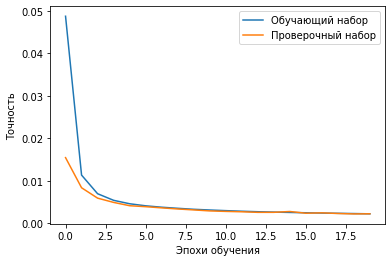

In [7]:
model = createConvModel()
model.summary()
history = model.fit(xtrain, xtrain, batch_size=256, epochs=20, verbose=0, validation_data=(xtest, xtest))
plotGraph(history.history['loss'], history.history['val_loss'])


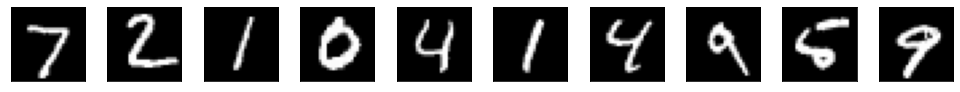

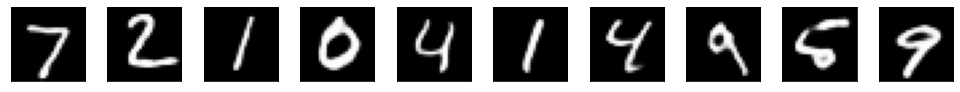

In [8]:
predict = model.predict(xtest)
plotImages(0, xtest)
plotImages(0, predict)

При помощи автокодировщиков можно "восстанавливать" информацию (убирать шумы, восстанавливать обрезанные части и т.д.). 
Для этого надо соответствующим образом обучить нейросеть.

Функция для обрезания части изображения (нарисует черный квадрат в произвольном месте)

In [9]:
def malevich(img, seed):
  center = 4 #по краям и так темно. немного подвинемся в центр картинки. теперь у нас поле 28-4-4=20 пикселей
  randx = rnd.randint(center, 27-seed-center*2)
  randy = rnd.randint(center, 27-seed-center*2)
  result = img.copy()
  result[randx:randx+seed, randy:randy+seed] = 0
  return result


исходное изображение


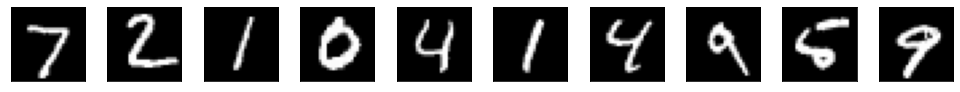

обрезанное изображение


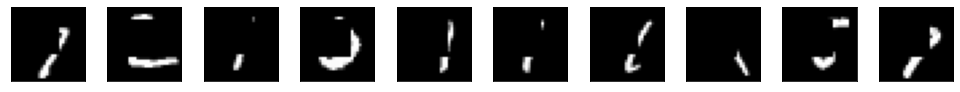

In [10]:
seed = 14 #Будет отрезана четверть изображения. ближе к центру.
xtrain_malevich = np.array([malevich(val, seed) for val in xtrain])
xtest_malevich = np.array([malevich(val, seed) for val in xtest])
print('исходное изображение')
plotImages(0, xtest)
print('обрезанное изображение')
plotImages(0, xtest_malevich)

Обучим можель восстанавливать информацию.

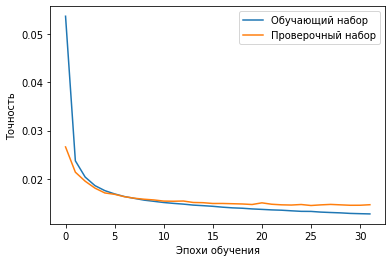

In [11]:
model = createConvModel()
history = model.fit(xtrain_malevich, xtrain, batch_size=256, epochs=32, verbose=0, validation_data=(xtest_malevich, xtest))
plotGraph(history.history['loss'], history.history['val_loss'])

Проверим результат

Исходное изображение


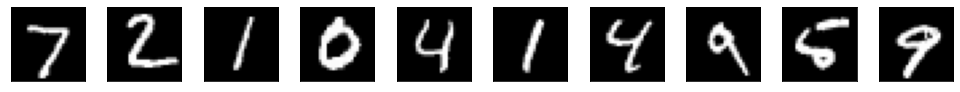

Обрезанное изображение


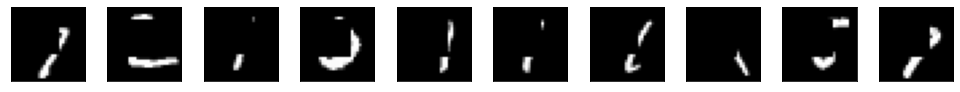

Восстановленное изображение


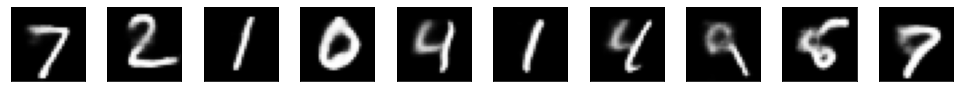

In [14]:
predict = model.predict(xtest_malevich)
print('Исходное изображение')
plotImages(0, xtest)
print('Обрезанное изображение')
plotImages(0, xtest_malevich)
print('Восстановленное изображение')
plotImages(0, predict)